alfie pymongo use

In [96]:
import os
from dotenv import load_dotenv
from pathlib import Path
from pymongo import MongoClient
import matplotlib.pyplot as plt
import pandas as pd
import ast
import datetime
import seaborn as sns
import json
import numpy as np

import matplotlib as mpl

from datetime import datetime
from dateutil.parser import parse

#need to translate from wgs to bng to do spatial clustering
import pyproj

from pandas.io.json import json_normalize

#now to try out the clustering with this new data set
#now import DBSCAN clustering package
from sklearn.cluster import DBSCAN

#import hierarchical clustering
from scipy import cluster

In [2]:
# specifies number of rows to show
pd.set_option('display.max_rows', 300) 

# specifies default number format to 4 decimal places
pd.options.display.float_format = '{:40,.4f}'.format 

# specifies that graphs should use ggplot styling
plt.style.use('ggplot') 

%matplotlib inline

## Some setups

In [3]:
pd.set_option('display.max_rows', 300) # specifies number of rows to show
pd.options.display.float_format = '{:40,.4f}'.format # specifies default number format to 4 decimal places
%matplotlib inline

In [4]:
from astropy.stats import RipleysKEstimator

In [5]:
# load .env variable
# base_dir = 'D:\Documentos\GitHub\CityBlender'
# dotenv_file = os.path.join(base_dir, '.env')

base_dir = 'C:/Users/Alfie/Documents/MSc Smart Cities/Term 2/Spatial Data Capture Storage and Analysis/Coursework/Analysis Test/'
dotenv_file = os.path.join(base_dir, '.env')


# Continue loading stuff

if os.path.isfile(dotenv_file):
    load_dotenv(dotenv_file, verbose=True)
    
db_uri = os.getenv('DB_URI')

db_client = MongoClient(str(db_uri))


# choose a database to connect to (.london)
db_london = db_client.london
status = db_client.london.command('serverStatus')


# create the connections and build the local datasets
db_london_events = db_london['events']
db_london_artist = db_london['artists']

allLondonEvents = db_london_events.find()

londonEventsdf = pd.DataFrame(list(allLondonEvents))

C:\Users\Alfie\Anaconda3\lib\site-packages\pymongo\common.py:555: UserWarning: Unknown option retryWrites
  warnings.warn(str(exc))


# Some processing

In [6]:
# Put this in the date format
londonEventsdf['date'] = [(datetime.strptime(londonEventsdf['date'][x], '%Y-%m-%d')) for x in range(len(londonEventsdf['date']))]

# Convert the dates into day name
londonEventsdf['date_name'] = [(londonEventsdf['date'][x].strftime("%A")) for x in range(len(londonEventsdf['date']))]

# Lat & Long
londonEventsdf['lat'] = [(londonEventsdf['location'][x]['lat']) for x in range(len(londonEventsdf['location']))]
londonEventsdf['lng'] = [(londonEventsdf['location'][x]['lng']) for x in range(len(londonEventsdf['location']))]

# Dates in the dataset

In [7]:
#get min and max date of this dataset
print(min(londonEventsdf['date']))
print(max((londonEventsdf['date'])))

2018-04-13 00:00:00
2018-05-27 00:00:00


In [8]:
# Define some common projections using EPSG codes
wgs84=pyproj.Proj("+init=EPSG:4326") # LatLon with WGS84 datum used by GPS units and Google Earth
osgb36=pyproj.Proj("+init=EPSG:27700") # UK Ordnance Survey, 1936 datum

In [9]:
#create a new pd without NaNs
londonEventsdfNoNan = londonEventsdf[londonEventsdf['lat'].notnull()]

#make new columns for the new latlng
londonEventsdfNoNan['BNGnorthing'] = ""
londonEventsdfNoNan['BNGeasting'] = ""


londonEventsdfNoNan = londonEventsdfNoNan.reset_index()

C:\Users\Alfie\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\Alfie\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [10]:
#now run through the dataset and transform those coordinates
origLat = []
origLng = []

for i in londonEventsdfNoNan['index']:
    # print(i)
    try:
        origLat.append(londonEventsdfNoNan['lat'][i])
        origLng.append(londonEventsdfNoNan['lng'][i])
        
    except:
        origLat.append(np.nan)
        origLng.append(np.nan)

In [11]:
lat,lon = pyproj.transform(wgs84,osgb36,origLng,origLat)
    
londonEventsdfNoNan['BNGeasting'] = lat
londonEventsdfNoNan['BNGnorthing'] = lon

In [12]:
londonEventsdfNoNan

,index,_id,artists,date,datetime,datetime_source,foursquare,id,lastfm,location,...,spotify,time,type,url,venue,date_name,lat,lng,BNGnorthing,BNGeasting
0,0,5af9c6dc0cc9ab0004e227d1,[{'mbid': ['aca5718f-4f49-4439-b8f6-209db3f117...,2018-05-14,2018-05-14 18:00:00,2018-05-14T19:00:00+0100,"{'id': '4ac518e9f964a520daab20e3', 'name': 'Ro...",31245569,"{'listeners': [412072, 57, 192843], 'listeners...","{'lng': -0.1491962, 'lat': 51.5429551}",...,"{'genres': [], 'popularity': [64, 25, 32], 'po...",19:00:00,Concert,http://www.songkick.com/concerts/31245569-fran...,"{'id': 17874, 'name': 'Roundhouse', 'location'...",Monday,51.5430,-0.1492,"184,296.1993","528,443.9440"
1,1,5af9c6de0cc9ab0004e227d3,"[{'mbid': [], 'id': 8437833, 'name': 'Andy May...",2018-05-14,NaT,None,"{'id': '4ac518c5f964a520afa420e3', 'name': 'Th...",31640764,"{'listeners': [18], 'listeners_sum': 18, 'play...","{'lng': -0.1011681, 'lat': 51.5233496}",...,"{'genres': [], 'popularity': [3], 'popularity_...",None,Concert,http://www.songkick.com/concerts/31640764-andy...,"{'id': 6950, 'name': 'The Slaughtered Lamb', '...",Monday,51.5233,-0.1012,"182,201.3522","531,830.8516"
2,2,5af9c6e30cc9ab0004e227d6,[{'mbid': ['6655955b-1c1e-4bcb-84e4-81bcd9efab...,2018-05-14,2018-05-14 17:45:00,2018-05-14T18:45:00+0100,"{'id': '4ac518e8f964a52075ab20e3', 'name': 'Ro...",31785344,"{'listeners': [721424, 19477], 'listeners_sum'...","{'lng': -0.1781517, 'lat': 51.500786}",...,"{'genres': ['bow pop', 'chamber pop', 'composi...",18:45:00,Concert,http://www.songkick.com/concerts/31785344-olaf...,"{'id': 17538, 'name': 'Royal Albert Hall', 'lo...",Monday,51.5008,-0.1782,"179,556.4100","526,552.8784"
3,3,5af9c6e50cc9ab0004e227d8,[{'mbid': ['d100e4ac-31f1-4af1-b0e1-f07c545abb...,2018-05-14,2018-05-14 18:00:00,2018-05-14T19:00:00+0100,"{'id': '53713174498e54bcdede7275', 'name': 'Up...",32044684,"{'listeners': [313], 'listeners_sum': 313, 'pl...","{'lng': -0.1038429, 'lat': 51.5466983}",...,"{'genres': ['scottish folk'], 'popularity': [3...",19:00:00,Concert,http://www.songkick.com/concerts/32044684-elep...,"{'id': 434301, 'name': 'Thousand Island (forme...",Monday,51.5467,-0.1038,"184,792.9986","531,578.0036"
4,4,5af9c6eb0cc9ab0004e227db,[{'mbid': ['366323f3-0409-4a30-a3e9-ce1e25d277...,2018-05-14,2018-05-14 18:30:00,2018-05-14T19:30:00+0100,"{'id': '4b5e0cfdf964a520037b29e3', 'name': 'Bu...",32192284,"{'listeners': [7057, 3625], 'listeners_sum': 1...","{'lng': -0.2314873, 'lat': 51.5062847}",...,"{'genres': [], 'popularity': [25, 1], 'popular...",19:30:00,Concert,http://www.songkick.com/concerts/32192284-gary...,"{'id': 17541, 'name': 'Bush Hall', 'location':...",Monday,51.5063,-0.2315,"180,077.1048","522,836.2963"
5,5,5af9c6ed0cc9ab0004e227dd,[{'mbid': ['a1ef6bc8-2644-4b6d-aa21-27b630acf7...,2018-05-14,2018-05-14 18:30:00,2018-05-14T19:30:00+0100,{},32454499,"{'listeners': [113695], 'listeners_sum': 11369...","{'lng': -0.5541293, 'lat': 51.2486437}",...,"{'genres': ['pub rock', 'roots rock'], 'popula...",19:30:00,Concert,http://www.songkick.com/concerts/32454499-nils...,"{'id': 1262471, 'name': 'G Live', 'location': ...",Monday,51.2486,-0.5541,"150,934.1232","501,010.1269"
6,6,5af9c6ef0cc9ab0004e227df,[{'mbid': ['c1982570-8efb-4cf7-bb5b-c9c026c0e8...,2018-05-14,2018-05-14 18:00:00,2018-05-14T19:00:00+0100,"{'id': '59bbad4dfebf314eba5d9fbb', 'name': 'Br...",32492684,"{'listeners': [120157], 'listeners_sum': 12015...","{'lng': -0.0774607, 'lat': 51.5033289}",...,"{'genres': ['afropop', 'world'], 'popularity':...",19:00:00,Concert,http://www.songkick.com/concerts/32492684-lady...,"{'id': 3565864, 'name': 'Bridge Theatre', 'loc...",Monday,51.5033,-0.0775,"180,017.9391","533,533.9375"
7,7,5af9c6f00cc9ab0004e227e1,"[{'mbid': [], 'id': 6651674, 'name': 'Gemma Kh...",2018-05-14,2018-05-14 18:00:00,2018-05-14T19:00:00+0100,"{'id': '53aa2db3498e191dfd67bd05', 'name': 'Fo...",32649974,"{'listeners': [32], 'listeners_sum': 32, 'play...","{'lng': -0.1355174, 'lat': 51.5403054}",...,NaN,19:00:00,Concert,h

In [13]:
londonEventsdfNoNan['BNGnorthing'] = pd.to_numeric(londonEventsdfNoNan['BNGnorthing'])
londonEventsdfNoNan['BNGeasting'] = pd.to_numeric(londonEventsdfNoNan['BNGeasting'])

In [80]:
minNorthLdn = min(londonEventsdfNoNan['BNGnorthing'])
minEastLdn = min(londonEventsdfNoNan['BNGeasting'])
maxNorthLdn = max(londonEventsdfNoNan['BNGnorthing'])
maxEastLdn = max(londonEventsdfNoNan['BNGeasting'])

In [15]:
londonEventsdfNoNan = londonEventsdfNoNan[londonEventsdfNoNan['BNGnorthing'].notnull()]

In [16]:
londonEventsdfNoNan = londonEventsdfNoNan.reset_index()

In [17]:
# Make a function to subset the genere depending on which dataset
def subset_by_genere(db = londonEventsdfNoNan, lib = 'spotify', words = 'reggae'):
    return db[db[lib].astype(str).str.contains(words, case=False)]

In [18]:
reggaeEventsdf = subset_by_genere()

reggaeEventsdf2 = subset_by_genere(lib = 'lastfm')
allReggaeEvents = pd.concat([reggaeEventsdf,reggaeEventsdf2])

In [19]:
#get rid of duplicates
allReggaeEvents = allReggaeEvents.drop_duplicates(subset='_id', keep='last')

In [25]:
#try folk subset
folkEvents = subset_by_genere(words = 'folk')

In [26]:
folkEvents2 = folkEvents = subset_by_genere(lib = 'lastfm', words = 'folk')

In [27]:
allFolkEvents = pd.concat([folkEvents,folkEvents2])

In [28]:
allFolkEvents = allFolkEvents.drop_duplicates(subset='_id', keep='last')

In [29]:
allFolkEvents

,level_0,index,_id,artists,date,datetime,datetime_source,foursquare,id,lastfm,...,spotify,time,type,url,venue,date_name,lat,lng,BNGnorthing,BNGeasting
0,0,0,5af9c6dc0cc9ab0004e227d1,[{'mbid': ['aca5718f-4f49-4439-b8f6-209db3f117...,2018-05-14,2018-05-14 18:00:00,2018-05-14T19:00:00+0100,"{'id': '4ac518e9f964a520daab20e3', 'name': 'Ro...",31245569,"{'listeners': [412072, 57, 192843], 'listeners...",...,"{'genres': [], 'popularity': [64, 25, 32], 'po...",19:00:00,Concert,http://www.songkick.com/concerts/31245569-fran...,"{'id': 17874, 'name': 'Roundhouse', 'location'...",Monday,51.5430,-0.1492,"184,296.1993","528,443.9440"
4,4,4,5af9c6eb0cc9ab0004e227db,[{'mbid': ['366323f3-0409-4a30-a3e9-ce1e25d277...,2018-05-14,2018-05-14 18:30:00,2018-05-14T19:30:00+0100,"{'id': '4b5e0cfdf964a520037b29e3', 'name': 'Bu...",32192284,"{'listeners': [7057, 3625], 'listeners_sum': 1...",...,"{'genres': [], 'popularity': [25, 1], 'popular...",19:30:00,Concert,http://www.songkick.com/concerts/32192284-gary...,"{'id': 17541, 'name': 'Bush Hall', 'location':...",Monday,51.5063,-0.2315,"180,077.1048","522,836.2963"
5,5,5,5af9c6ed0cc9ab0004e227dd,[{'mbid': ['a1ef6bc8-2644-4b6d-aa21-27b630acf7...,2018-05-14,2018-05-14 18:30:00,2018-05-14T19:30:00+0100,{},32454499,"{'listeners': [113695], 'listeners_sum': 11369...",...,"{'genres': ['pub rock', 'roots rock'], 'popula...",19:30:00,Concert,http://www.songkick.com/concerts/32454499-nils...,"{'id': 1262471, 'name': 'G Live', 'location': ...",Monday,51.2486,-0.5541,"150,934.1232","501,010.1269"
9,9,9,5af9c6f60cc9ab0004e227e6,[{'mbid': ['c2ca4e82-016c-4498-83e9-1d90e3811a...,2018-05-14,NaT,None,"{'id': '4ac518cdf964a520cca520e3', 'name': 'Th...",32839319,"{'listeners': [6411], 'listeners_sum': 6411, '...",...,"{'genres': ['deep new americana'], 'popularity...",None,Concert,http://www.songkick.com/concerts/32839319-bird...,"{'id': 34372, 'name': 'The Lexington', 'locati...",Monday,51.5317,-0.1114,"183,106.6804","531,094.0841"
16,16,16,5af9c70a0cc9ab0004e227f7,[{'mbid': ['6d7d92fa-36ea-4e32-8f68-2d421553f5...,2018-05-14,2018-05-14 18:30:00,2018-05-14T19:30:00+0100,"{'id': '4ac518c9f964a520a6a520e3', 'name': 'Th...",33264169,"{'listeners': [68, 29], 'listeners_sum': 97, '...",...,"{'genres': [], 'popularity': [0], 'popularity_...",19:30:00,Concert,http://www.songkick.com/concerts/33264169-davi...,"{'id': 517871, 'name': 'The Social', 'location...",Monday,51.5173,-0.1408,"181,452.7404","529,100.9014"
21,21,21,5af9c7190cc9ab0004e22802,[{'mbid': ['cb48142a-1e26-447e-b582-19a608834b...,2018-05-14,NaT,None,"{'id': '4ac518e9f964a520daab20e3', 'name': 'Ro...",33451594,"{'listeners': [2311, 2070, 5180], 'listeners_s...",...,"{'genres': [], 'popularity': [18, 10, 23], 'po...",None,Concert,http://www.songkick.com/concerts/33451594-rpms...,"{'id': 17874, 'name': 'Roundhouse', 'location'...",Monday,51.5430,-0.1492,"184,296.1993","528,443.9440"
43,43,43,5af9c75d0cc9ab0004e2283b,[{'mbid': ['b8dee82d-21e4-44a8-ba45-1293e381c8...,2018-05-15,2018-05-15 19:00:00,2018-05-15T20:00:00+0100,{},32389524,"{'listeners': [7952], 'listeners_sum': 7952, '...",...,"{'genres': [], 'popularity': [29], 'popularity...",20:00:00,Concert,http://www.songkick.com/concerts/32389524-alla...,"{'id': 548961, 'name': 'The Ram Club', 'locati...",Tuesday,51.3855,-0.3313,"166,486.9450","516,214.1325"
44,44,44,5af9c7600cc9ab0004e2283e,[{'mbid': ['aa22f8bc-2aeb-4dff-87b8-0fc89b9d4f...,2018-05-15,2018-05-15 18:00:00,2018-05-15T19:00:00+0100,"{'id': '4ac518c7f964a52072a520e3', 'name': 'Ja...",32394614,"{'listeners': [22687, 437], 'listeners_sum': 2...",...,"{'genres': ['chamame', 'nu-cumbia'], 'populari...",19:00:00,Concert,http://www.songkick.com/concerts/32394614-la-y...,"{'id': 7404, 'name': 'The Jazz Cafe', 'locatio...",Tuesday,51.5387,-0.1431,"183,834.7825","528,879.9304"
48,48,48,5af9c76b0cc9ab0004e22848,[{'mbid': ['ba1bf556-2af2-4772-835f-ed2e150707...,2018-05-15,2018-05-15 18:00:00,2018-05-15T19:00:00+0100,"{'id': '4ac518d3f964a5204da720e3', 'name': 'Ba..

In [ ]:
allReggaeEvents

In [81]:
print(minEastLdn)
print(minNorthLdn)
print(maxEastLdn)
print(maxNorthLdn)

390106.0032924241
113507.49788016273
577698.9812722136
334032.00796293287


In [93]:
#now set up the ripley's k estimator object
Kest = RipleysKEstimator(area=30000,x_max=maxEastLdn, y_max=maxNorthLdn, x_min=minEastLdn, y_min=minNorthLdn)

In [39]:
#need to put the lat and lng as an array
locsAsArray = londonEventsdfNoNan[['BNGeasting', 'BNGnorthing']].values

In [40]:
locsAsArray

array([[528443.94399086, 184296.1992924 ],
       [531830.85157365, 182201.35215564],
       [526552.87843406, 179556.41004052],
       ...,
       [533771.26412053, 185408.21037611],
       [530559.98640155, 174459.69037784],
       [534987.97735407, 184950.06582492]])

In [32]:
#now get reggae locs
regLocsAsArray = allReggaeEvents[['BNGeasting', 'BNGnorthing']].values

In [33]:
regLocsAsArray

array([[529125.61048824, 185941.96443282],
       [522836.29627684, 180077.10483475],
       [531578.00360498, 184792.99859854],
       [533592.88873429, 184869.09853393],
       [528879.9303679 , 183834.78247509],
       [531233.00721267, 176354.99904255],
       [528879.9303679 , 183834.78247509],
       [531750.93776357, 181776.8117577 ],
       [528879.9303679 , 183834.78247509],
       [531468.85466627, 183442.06794751],
       [533551.44261062, 183728.69882221],
       [528901.42231654, 185330.15394723],
       [528980.95238692, 183852.24752122],
       [526552.87843406, 179556.41004052],
       [528879.9303679 , 183834.78247509],
       [528879.9303679 , 183834.78247509],
       [529492.48324492, 181334.4143296 ],
       [537640.58425858, 184575.16995948],
       [534709.00608233, 183367.97959341],
       [531750.93776357, 181776.8117577 ],
       [531468.85466627, 183442.06794751],
       [528970.9982153 , 183847.18755029],
       [531527.80544902, 183211.26800206],
       [523

In [35]:
folkLocsAsArray = allFolkEvents[['BNGeasting', 'BNGnorthing']].values

In [36]:
folkLocsAsArray


array([[528443.94399086, 184296.1992924 ],
       [522836.29627684, 180077.10483475],
       [501010.12691495, 150934.12322069],
       [531094.08409589, 183106.68041871],
       [529100.90136236, 181452.74043263],
       [528443.94399086, 184296.1992924 ],
       [516214.13251954, 166486.94495816],
       [528879.9303679 , 183834.78247509],
       [532497.84395709, 181830.87595402],
       [531830.85157365, 182201.35215564],
       [532497.84395709, 181830.87595402],
       [531527.80544902, 183211.26800206],
       [530031.78330189, 180374.70753248],
       [528702.00692506, 183687.00206079],
       [534786.00616346, 185020.002465  ],
       [531094.08409589, 183106.68041871],
       [523614.61006884, 175818.90644987],
       [529100.90136236, 181452.74043263],
       [530559.98640155, 174459.69037784],
       [523309.6366606 , 178373.89311545],
       [534445.00146706, 183235.00209657],
       [532497.84395709, 181830.87595402],
       [528497.03976639, 184315.59180979],
       [531

C:\Users\Alfie\Anaconda3\lib\site-packages\astropy\stats\spatial.py:264: RuntimeWarning: divide by zero encountered in true_divide
  c2 = 2 * np.arcsin((1 / x) * (x > 1)) - 1 / b - 2 * (x - u)
C:\Users\Alfie\Anaconda3\lib\site-packages\astropy\stats\spatial.py:264: RuntimeWarning: invalid value encountered in multiply
  c2 = 2 * np.arcsin((1 / x) * (x > 1)) - 1 / b - 2 * (x - u)
C:\Users\Alfie\Anaconda3\lib\site-packages\astropy\stats\spatial.py:264: RuntimeWarning: invalid value encountered in arcsin
  c2 = 2 * np.arcsin((1 / x) * (x > 1)) - 1 / b - 2 * (x - u)
C:\Users\Alfie\Anaconda3\lib\site-packages\astropy\stats\spatial.py:267: RuntimeWarning: divide by zero encountered in true_divide
  + 2 * u + 2 * v / b - b - (1 + x * x) / b)
C:\Users\Alfie\Anaconda3\lib\site-packages\astropy\stats\spatial.py:267: RuntimeWarning: invalid value encountered in multiply
  + 2 * u + 2 * v / b - b - (1 + x * x) / b)
C:\Users\Alfie\Anaconda3\lib\site-packages\astropy\stats\spatial.py:267: RuntimeWar

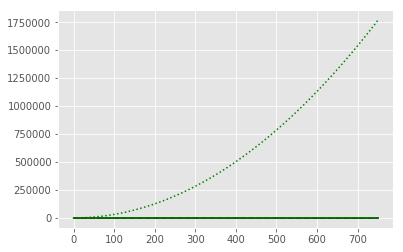

In [95]:
#now to plot and have a look
r = np.linspace(0, 750, num = 100)
# plt.plot(r, Kest.poisson(r), color='green', ls=':', label=r'$K_{pois}$')
plt.plot(r, Kest(data=folkLocsAsArray, radii=r, mode='none'), color='red', ls='--',
         label=r'$K_{un}$')
plt.plot(r, Kest(data=folkLocsAsArray, radii=r, mode='translation'), color='black',
         label=r'$K_{trans}$')
plt.plot(r, Kest(data=folkLocsAsArray, radii=r, mode='ohser'), color='blue', ls='-.',
         label=r'$K_{ohser}$')
plt.plot(r, Kest(data=folkLocsAsArray, radii=r, mode='var-width'), color='green',
         label=r'$K_{var-width}$')
plt.plot(r, Kest(data=folkLocsAsArray, radii=r, mode='ripley'), color='yellow',
         label=r'$K_{ripley}$')



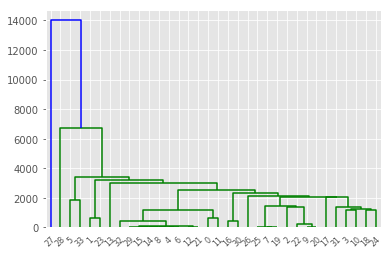

In [97]:
#Ripley's k is rubbish, let's try using hierarchical clustering to work out how large to set the eps
regCluster = cluster.hierarchy.linkage(regLocsAsArray)
cluster.hierarchy.dendrogram(regCluster);


In [73]:
#try out a dbscan of all reggae
#create new dbscan cluster object
dbscan = DBSCAN(eps=1000, min_samples=10)

In [74]:
#get only locations from the reggae set
#get just locations
#use the locsArray again

dbscanAllEvents = dbscan.fit(locsAsArray)

In [75]:
#get the labels of the groups
dbscanLabelsAllEvents = dbscan.labels_

In [76]:
dbscanLabelsAllEvents

array([0, 0, 1, ..., 0, 9, 0], dtype=int64)

In [77]:
#now add the labels back into the reggae dataframe
#need to reindex allReggaeEvents for it to work
#londonEventsdfNoNan = londonEventsdfNoNan.reset_index()

In [78]:
londonEventsdfNoNan['dbscanLabelsAllEvents'] = pd.DataFrame(dbscanLabelsAllEvents)

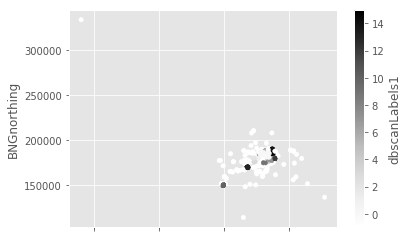

In [79]:
#now give it a plot
#define colorscheme

londonEventsdfNoNan.plot.scatter(y='BNGnorthing', x='BNGeasting', c='dbscanLabelsAllEvents', )

In [ ]:
#try clustering out on the whole dataset
dbscan2ndRun = dbscan.fit(locsAsArray)

In [ ]:
londonEventsdf